In [30]:
##### Data and libraries

# Common libraries
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import seaborn as sns

# Chapter-specific libraries
import statsmodels.stats.outliers_influence as st_inf # For Cook's distance
import matplotlib.pyplot as plt
import statsmodels.api as sm # For QQ plot

### Generating the data

times = [2,2,3,5,6,9,10,47,61,413]
experience = [11,17,18,1,10,4,6,3,8,0]

data_df = pd.DataFrame(
    {'times': times, 
    'experience': experience})

In [31]:
#  calculating upper and lower confidence intervals for sample mean
lin_mod = ols("times~1", data=data_df).fit()
est = lin_mod.params['Intercept']
se = lin_mod.bse['Intercept']
LL = est-1.96*se
UL = est+1.96*se
print(f'Lower Limit: {LL}\nUpper Limit: {UL}')

Lower Limit: -23.040199740431348
Upper Limit: 134.64019974043134


In [32]:
boot_df = data_df.sample(len(data_df), replace=True) # sampling dataset with replacement
boot_df

,times,experience
2,3,18
5,9,4
6,10,6
2,3,18
5,9,4
5,9,4
4,6,10
9,413,0
9,413,0
0,2,11


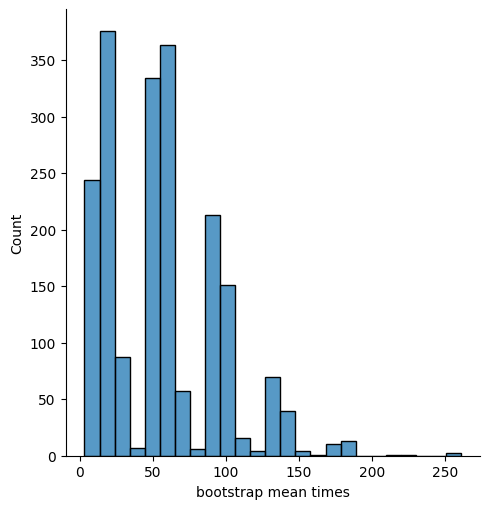

In [33]:
%matplotlib inline
res_boot_sim = []
B = 2000
N = len(data_df)
for i in range(B):
    boot_df = data_df.sample(N, replace=True)
    M = np.mean(boot_df.times)
    res_boot_sim.append(M)

g = sns.displot(res_boot_sim, kind='hist')
g.set_axis_labels('bootstrap mean times')

In [34]:
# constructing CI from bootstrap
# values will vary across resamples as they are randomly generated
LL_b = np.quantile(res_boot_sim, 0.025)
UL_b = np.quantile(res_boot_sim, 0.975)
print(f"Lower Limit Boostrap: {LL_b}\nUpper Limit Bootstrap: {UL_b}")

Lower Limit Boostrap: 5.8
Upper Limit Bootstrap: 141.2


In [35]:
# event probability bootstrap
promise_list = []
B = 2000
N = len(data_df)
for i in range(B):
    boot_df = data_df.sample(N, replace=True)
    above180 = len(boot_df[boot_df.times >= 180]) / N
    promise_list.append(above180)

LL_b = np.quantile(promise_list, 0.025)
UL_b = np.quantile(promise_list, 0.975)

print(f"Lower Limit Boostrap: {LL_b}\nUpper Limit Bootstrap: {UL_b}")

Lower Limit Boostrap: 0.0
Upper Limit Bootstrap: 0.3


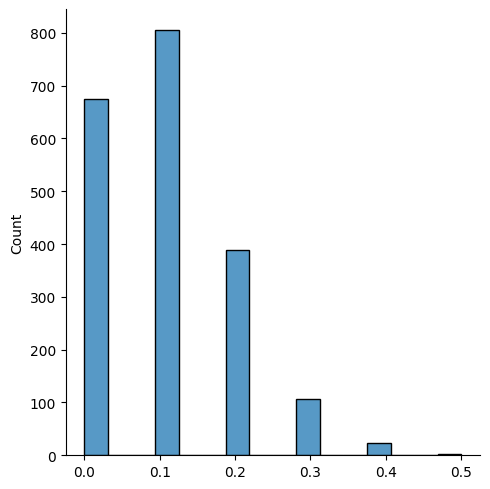

In [36]:
sns.displot(promise_list)

In [37]:
print(ols("times~experience", data=data_df).fit().summary())

                            OLS Regression Results                            
Dep. Variable:                  times   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     2.427
Date:                Fri, 10 Nov 2023   Prob (F-statistic):              0.158
Time:                        11:10:52   Log-Likelihood:                -60.795
No. Observations:                  10   AIC:                             125.6
Df Residuals:                       8   BIC:                             126.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    132.3891     61.750      2.144      0.0

/home/beastman/anaconda3/envs/bda/lib/python3.12/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [46]:
# regression with bootstrap
reg_list = []
B = 200
N = len(data_df)
for i in range(B):
    boot_df = data_df.sample(N, replace=True)
    lin_mod_b = ols("times~experience", data=boot_df).fit()
    coeff = lin_mod_b.params['experience']
    reg_list.append(coeff)

LL_b = np.quantile(reg_list, 0.025)
UL_b = np.quantile(reg_list, 0.975)

print(f"Lower Limit Boostrap: {LL_b}\nUpper Limit Bootstrap: {UL_b}")

Lower Limit Boostrap: -26.260000420160395
Upper Limit Bootstrap: 0.22257399247445053


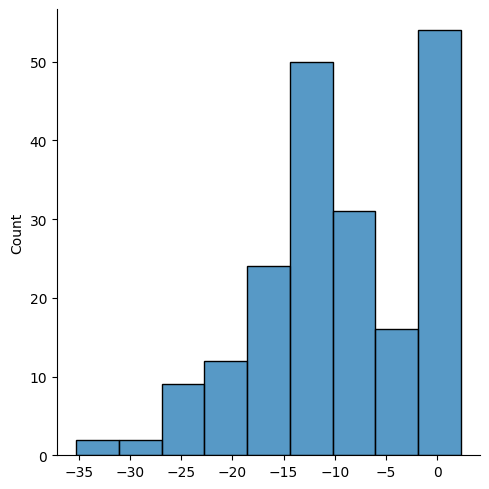

In [47]:
sns.displot(reg_list)

In [44]:
p_val = 2 * sum(1 for x in reg_list if x > 0) / B # proportion of coefficients greater than 0 in the bootstrap sample sets
p_val

0.02

In [41]:
CD = st_inf.OLSInfluence(lin_mod).summary_frame()['cooks_d']
CD[CD > 1]

Series([], Name: cooks_d, dtype: float64)

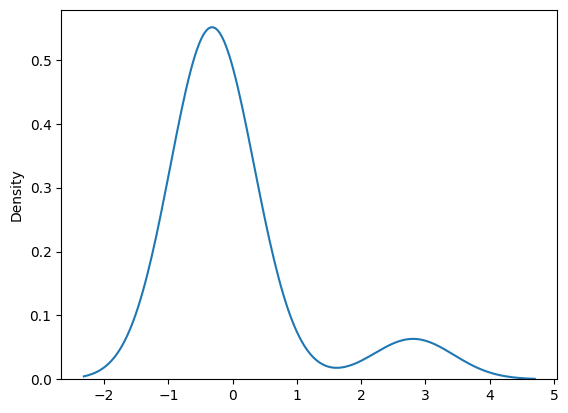

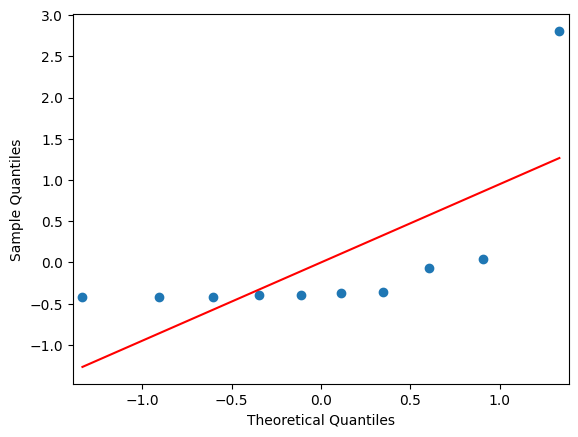

In [42]:
res_df = lin_mod.resid_pearson
sns.kdeplot(res_df)
flg = sm.qqplot(res_df, line='s')
plt.show()

In [ ]:
# optimizing Bootstrap with NumPy

data_ar = data_df.to_numpy() # pandas dataframe to numpy array
rng = np.random.default_rng() # initialize NumPy generator outside loop

np_list = []
for i in range(B):
    boot_ar = rng.choice(data_ar, size=N, replace=True) # numpy random generator faster than pandas sample
    X = boot_ar[:,1] # extract predictors from array and add constant column for intercept
    X = np.c_[X, np.ones(N)] 
    Y = boot_ar[:, 0] # extract dv column for array

    # fit a linear regression using lstsq
    np_list.append(
        np.linalg.lstsql(
            X, Y,
              rcond=-1 # removes a warning
            )[0][0] # extract only the value we want from this model
        ) 